# Fuel Filter using Lowpass Butterwoth Filter: Version 1.0

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard Python libraries
import os  # Provides functions to interact with the operating system (e.g., file handling).
import json  # Used for parsing and working with JSON data.
import glob  # Enables pattern matching to find all files of a specified type.

import pandas as pd  # Powerful library for data manipulation and analysis using DataFrames.
import matplotlib.pyplot as plt  # Used for creating static, animated, and interactive visualizations in Python.

# Signal processing libraries
from scipy.signal import savgol_filter, butter, filtfilt  # Functions for applying smoothing filters to data.

# Time manipulation library
from datetime import timedelta  # Used for manipulating and comparing time durations.


### Function Checks the Latest Stability Fuel Level (Not used for this)

In [ ]:
# Define function to get the latest stable fuel level
def get_latest_stable_fuel_level(df, stability_threshold=10, stability_duration_minutes=10):
    """
    This function iterates through the DataFrame to identify the latest stable fuel level
    based on the given stability threshold and duration.

    Args:
        df (pd.DataFrame): DataFrame with 'smoothed_fuel_level' and 'timestamp' columns.
        stability_threshold (int, optional): The maximum allowed difference between consecutive
                                             fuel levels to be considered stable. Defaults to 10.
        stability_duration_minutes (int, optional): The minimum duration (in minutes) for which
                                                    the fuel level should remain within the
                                                    threshold to be considered stable. Defaults to 10.

    Returns:
        float: The latest stable fuel level.
    """
    df['timestamp'] = pd.to_datetime(df.index)
    stability_duration = timedelta(minutes=stability_duration_minutes)
    stable_level = df['smoothed_fuel_level'].iloc[0]
    stable_start_time = df['timestamp'].iloc[0]
    latest_stable_level = stable_level
    # print(df.head())
    for i, row in df.iterrows():
        current_time = row['timestamp']
        current_level = row['smoothed_fuel_level']

        if current_time - stable_start_time >= stability_duration:
          if abs(current_level - stable_level) > stability_threshold:
                # latest_stable_level = stable_level
                stable_level = current_level
                stable_start_time = current_time

    return stable_level

### Lowpass Butterworth Filter

In [3]:

# Define filter parameters
cutoff_frequency = 0.01  # Define the cutoff frequency for the filter
sampling_rate = 2       # Sampling rate for the resampled data
order = 3               # Order of the Butterworth filter


In [4]:
def butter_lowpass_filter(data, cutoff, fs, order=4):
    """
    Applies a Butterworth low-pass filter to the input data.

    Args:
        data (array-like): The input data to be filtered.
        cutoff (float): The cutoff frequency of the filter in Hz.
        fs (float): The sampling frequency of the data in Hz.
        order (int, optional): The order of the filter. Defaults to 4.

    Returns:
        array-like: The filtered data.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

### Function to process data and create data frame

In [5]:
def load_data_from_files(json_files):

    """Loads data from JSON files and yields data chunks as dictionaries."""
    for file_path in json_files:
        if file_path.endswith(".json"):
            # file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as f:
                try:
                    data = json.load(f)
                    geo_data = data["geoData"]

                    # Yield data chunks as dictionaries
                    for item in geo_data:
                        speed = float(item["speed"])
                        fuel_level = int(item["fuelLevelE2"]["$numberInt"])

                        yield {
                            "timestamp": pd.to_datetime(item["timeStamp"]["$date"]["$numberLong"], unit="ms"),
                            "fuelLevelE2": fuel_level,
                            "speed": speed,
                        }
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON in file {filename}: {e}")
                except KeyError as e:
                    print(f"Missing key in JSON data: {e}")

In [6]:
# Folder path and file names
main_directory = '/content/drive/MyDrive/json_files/'

# Recursively search for all JSON files in all subdirectories
json_files = glob.glob(os.path.join(main_directory, '**', '*.json'), recursive=True)

### Reampling the data for one minute

In [7]:
# Create a DataFrame from the generator
df = pd.DataFrame(load_data_from_files(json_files))

# Set 'timestamp' as index before resampling
# Necessary for resampling based on time intervals
df.set_index("timestamp", inplace=True)

# Resample the DataFrame to 1-minute intervals and forward fill missing data
resampled_df = df.resample("60S").mean().ffill()

<ipython-input-5-449c93be1d78>:18: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  "timestamp": pd.to_datetime(item["timeStamp"]["$date"]["$numberLong"], unit="ms"),


### Smoothing the signals
Without Considering the latest stable fuel function

In [8]:
# --- Smoothing and Speed Variation ---

# Apply smoothing filters - using vectorization for speed
resampled_df['fuelLevelE2_smoothed_savgol'] = savgol_filter(resampled_df['fuelLevelE2'], window_length=5, polyorder=3)
resampled_df['fuelLevelE2_smoothed_butter'] = butter_lowpass_filter(resampled_df['fuelLevelE2_smoothed_savgol'], cutoff_frequency, sampling_rate, order)
resampled_df['smoothed_fuel_level'] = resampled_df['fuelLevelE2_smoothed_butter']

# resampled_df['speed_smoothed_butter'] = butter_lowpass_filter(resampled_df['speed'], cutoff_frequency, sampling_rate, order)
resampled_df['speed_smoothed_savgol'] = savgol_filter(resampled_df['speed'], window_length=5, polyorder=3)
resampled_df['smoothed_speed'] = (resampled_df['speed_smoothed_savgol'])
resampled_df['speed_variation'] = resampled_df['smoothed_speed'].diff().abs()


### Plot the results

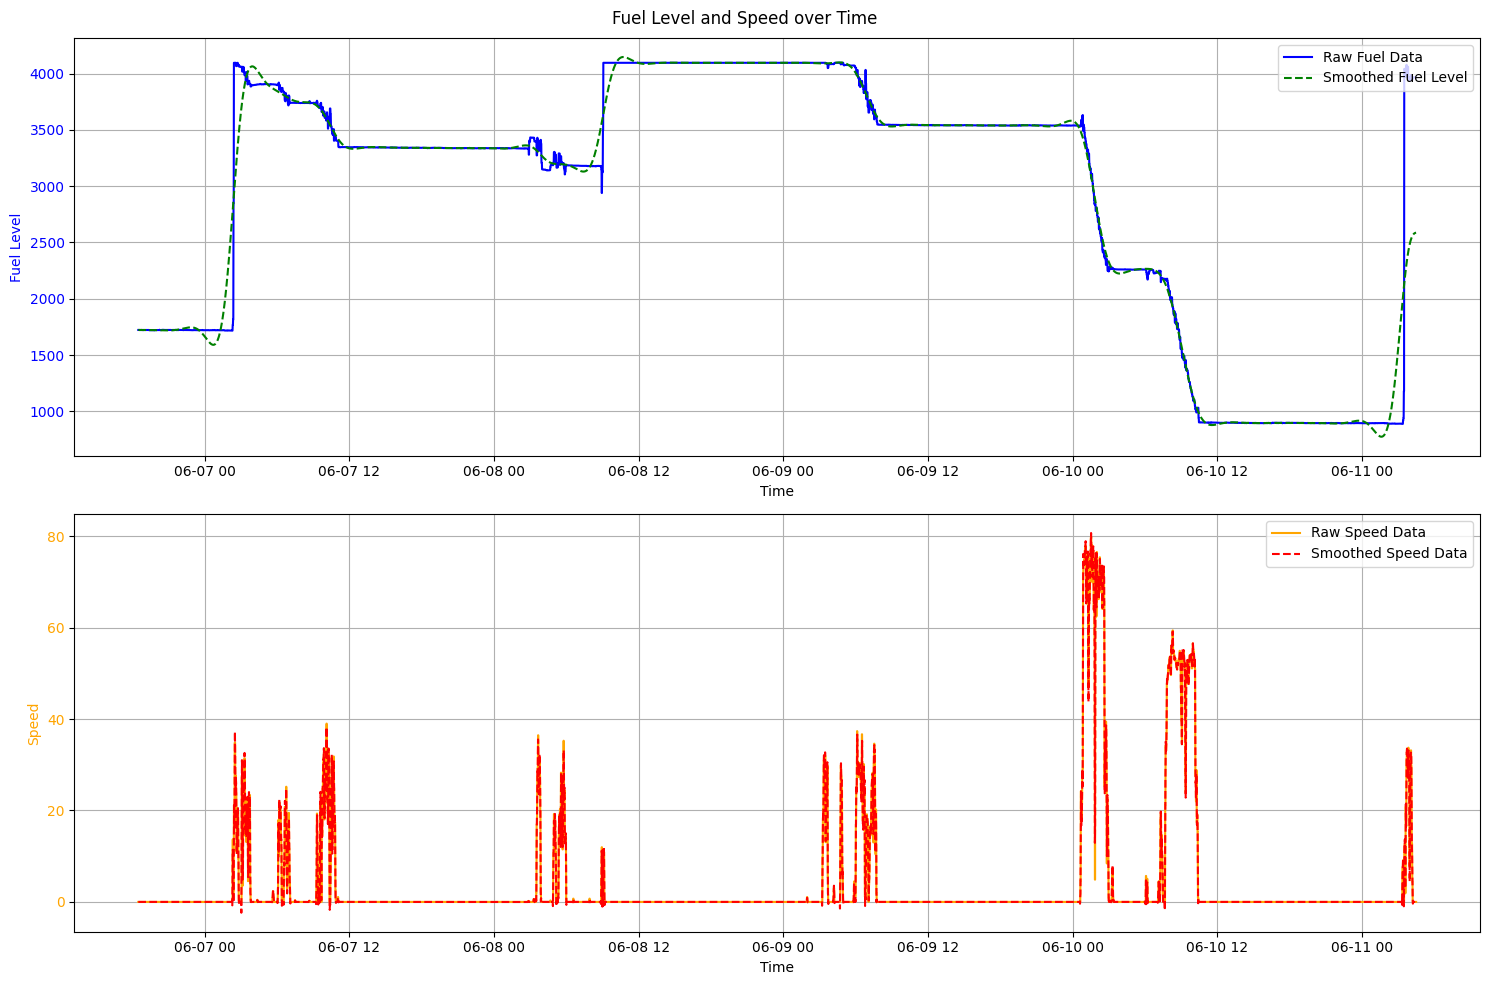

In [15]:
# --- Plotting ---

# Set figure size to make the graph wider
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))  # Make the figure wider and taller

# Plot Fuel Level
ax1.plot(resampled_df.index, resampled_df['fuelLevelE2'], label="Raw Fuel Data", color="blue")
ax1.plot(resampled_df.index, resampled_df['smoothed_fuel_level'], color='green', linestyle='--', label='Smoothed Fuel Level')


ax1.set_xlabel('Time')
ax1.set_ylabel('Fuel Level', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc="upper right")
ax1.grid()

# Plot Speed on a separate graph
ax2.plot(resampled_df.index, resampled_df['speed'], label="Raw Speed Data", color="orange")
ax2.plot(resampled_df.index, resampled_df['smoothed_speed'], label="Smoothed Speed Data", color="red", linestyle='--')

ax2.set_xlabel('Time')
ax2.set_ylabel('Speed', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc="upper right")
ax2.grid()

plt.suptitle('Fuel Level and Speed over Time')
plt.tight_layout()
plt.show()

### Fuel Liter Graph ans Speed

In [11]:
import numpy as np

In [12]:
# Calibration dataset
calibration_data = pd.DataFrame({
    'Actual Liter': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'fuelLevelE2': [86, 458, 834, 1189, 1562, 1924, 2266, 2626, 2981, 3334]
})

In [13]:
# Polynomial fit (optional if the relationship is non-linear)
coefficients = np.polyfit(calibration_data['fuelLevelE2'], calibration_data['Actual Liter'], deg=2)
poly_func = np.poly1d(coefficients)

# Apply the polynomial fit to the fuelLevelE2 data
resampled_df['fuel_liters'] = poly_func(resampled_df['smoothed_fuel_level'])

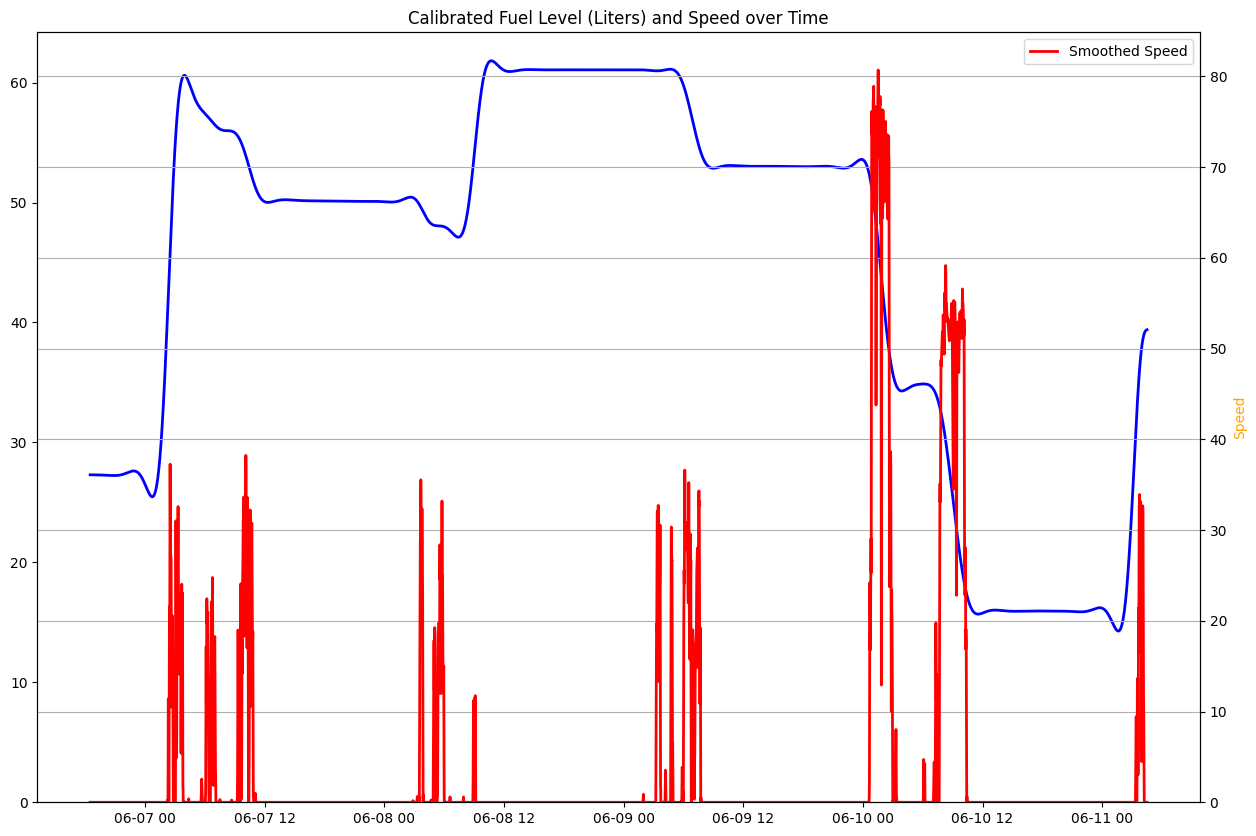

In [16]:
plt.figure(figsize=(15, 10))  # Increase the figure width for a wider plot

# Plot the calibrated fuel level on the primary y-axis (left)
plt.plot(resampled_df.index, resampled_df['fuel_liters'], color='blue', label='Calibrated Fuel Level (Liters)', linewidth=2)

# Set y-axis limits to start from 0 for fuel level
plt.ylim(0)  # Ensure the primary y-axis starts from 0


# Create a secondary y-axis for the speed data
ax2 = plt.gca().twinx()  # This creates a new y-axis that shares the same x-axis
ax2.plot(resampled_df.index, resampled_df['smoothed_speed'], color='red', label='Smoothed Speed', linewidth=2)

# Set y-axis limits to start from 0 for speed
ax2.set_ylim(0)  # Ensure the secondary y-axis starts from 0


# Set labels for both y-axes
plt.xlabel('Time')
plt.ylabel('Fuel Level (Liters)', color='green')  # Label for the fuel level axis
ax2.set_ylabel('Speed', color='orange')  # Label for the speed axis

# Set title
plt.title('Calibrated Fuel Level (Liters) and Speed over Time')

# Display legends for both lines
plt.legend(loc="upper left")  # Legend for the fuel level
ax2.legend(loc="upper right")  # Legend for the speed

# Enable grid
plt.grid(True)

# Show the plot
plt.show()
